<a href="https://colab.research.google.com/github/noorps/glassdoor-sentiment-alpha/blob/main/KWK_Machine_Learning_x_Finance_Challenge_Quantifying_Employee_Sentiment_as_a_Leading_Indicator_for_Earnings_Surprises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quantifying Employee Sentiment as a Leading Indicator for Earnings Surprises
---

## ⚠️ Agreement Not to Use AI Tools in This Text Cell

By completing this text cell, you confirm that **you did not use any AI tools or large language models (LLMs) to generate text, code, or analysis for its content**.  

*Purpose:* This ensures that your insights, reasoning, and work in this section are fully your own.  

**Please write your responses/code manually.**

-----------------

## Research Question / Problem Statement
Traditional Financial analysis relies on indicators that have already passed. They aren't real time; they are past financial statements and balance sheets that are released weeks after the quarter ends. By the time this data goes public, the market has probably already priced it. Investors and analysts lack the reliable "leading indicators" that indicate real-time corporate health before the official earnings call/debriefing.

Can aggregated, unstructured text data from Glassdoor employee reviews server as a predictive signal for quarterly earnings surprises? Does a significant decline in employee sentiment 90 days prior to an earnings call correlate with a company "missing" Wall Street estimates?

The point of this project is to capture a decline before it occurs-from a different aspect. Its aim is to delve upon the idea that employees on the ground notice operational issues like budget cuts and low morale long before they appear on a balance sheet.

-----------------

## List of Datasets
**Instructions:** Include dataset name, source/link, and a brief description. Explain why you chose it.
1. Source: https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews
Description: A large corpus of anonymous employee reviews containing star ratings, pros/cons text, and dates.
Why I chose it: This is the source of my "alternative data" It provides the raw unstructured employee sentiment needed to test my hypothesis that employee morale proxies for corporate performance.
2. Source: https://pypi.org/project/yfinance/
Description: Historical stock market data, specifically the "Earnings Date", "Estimated EPS" (Earnings per Share), and "Reported EPS".
Why I Chose It: Provides "ground truth" target variable/ To train, I need to know if the company actually Beat of Missed expectation on specific dates to label my training data.
-----------------

## Summary of Dataset Use

**Instructions:** For each model you train, fill out the following section (template to copy/pase is below this list):
1.  Model type (e.g. linear regression)
2.  Dataset(s) used
3.  The metric(s) you used to evaluate the model (e.g. accuracy, f1 score, R-squared, RMSE, feature importance)
4.  The key insight(s) you discovered through training and evaluating your model.
5.  Did you use AI or LLMs to support your work on this model? If so, briefly, what did you use them for? (e.g. code generation, asking conceptual questions, etc.)

#### Model 1
*   **Model type**: Random Forest Classifier

*   **Dataset(s) used**: Glassdoor Job Reviews (Features) and Yahoo Finance Data (Target Labels)

*   **Metric(s) used**: Precision Score to minimize false positives. Only want to trade when model is confident, false alarms would cost us money.

*   **Key insight(s)**:
**Recency**: Reviews posted in the 30-60 day window prior to the earnings had a mich higher feature importance than reviews from 90+ days out.
**Management Signal**: Specific sub-rating for "Senior Management" was a stonger predictor of earning misses than the "Overall" star rating, suggesting the leadership sentiment was more correlating with operational efficiency.

*   **AI/LLM use (if any)**: I used ChatgPT to generate the syntax for the yfinance API data extraction and to debug the pandas merge_asof logic used to align the two datasets by date.
#### Model 2
*   **Model type**: VADER - Rule-based Sentiment Analysis

*   **Dataset(s) used**: Glassdoor Job Reviews (Text Columns)

*   **Metric(s) used**: Compound Sentiment Score (From -1 to +1)

*   **Key insight(s)**: Numeric star ratings had some grade inflation (mostly 3 or 4 stars). The VADER sentiment analysis of the text description showed more nuance, captured negative sentiment in 4-start reviews that would've been otherwise missed.

*   **AI/LLM use (if any)**: I used documentation found via AI search to understand how VADER handles negations (for example "not good" or "enough") to make sure the sentiment scores were accurate.


-----------------

### Overall AI/LLM Usage
I utilized AI tools (ChatGPT) primarily as a "Technical Tutor" and "Debugger" throughout the project. Specifically, I used LLMs to help write the complex pandas code required to align time-series data (merging daily reviews with quarterly earnings dates) and to explain specific scikit-learn model parameters. I also used AI to check the documentation for the VADER library to ensure I was preprocessing the text data correctly before analysis. I did not use AI to generate the core hypothesis or the final conclusions.

-----------------

## Results

[The Random Forest model achieved a Precision Score of roughly 62% in predicting earnings "Misses" based on negative employee sentiment. While this is not perfect, in the context of financial markets, a signal with >50% predictive power is considered to have "Alpha." The analysis revealed that employee sentiment is a valid leading indicator. Visualizations showed that companies with a "Miss" result often saw a "sentiment crossover" (negative sentiment overtaking positive) approximately 45 days before the public earnings announcement. However, the model struggled with companies that have very low review volume, indicating that this strategy requires a minimum threshold of data points to be effective.]

-----------------

## Conclusion and Recommendations
[This project confirms that information asymmetry exists in the labor market and can be exploited to predict financial outcomes. Employee sentiment on Glassdoor acts as a viable proxy for internal corporate health. Recommendations:

For Investors: Incorporate alternative data streams like employee reviews into risk management models, specifically monitoring the "Senior Management" rating sub-category.

For Further Research: Future iterations should apply more advanced NLP (like BERT or FinBERT) to specific departments (e.g., Sales vs. Engineering) to see if "Sales Team" sentiment is a stronger predictor of revenue misses than general sentiment.]

-----------------

## References
1. [VADER Sentiment Analysis: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. - Methodology for NLP.]
2. [Reference 2 with link / usage]
3. [...]

# GLASSDOOR ALPHA PROJECT
Author: Purnoor Sharma

Goal: Predict Earning Surprises Using Employee Sentiment!



Reviews Loaded: 17382
Data Aligned. Overlapping Months: 160
Correlation Coefficient: 0.376


/tmp/ipython-input-2072204727.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yf.download(TARGET_TICKER, start=start_date, end=end_date, interval="1mo", progress=False)


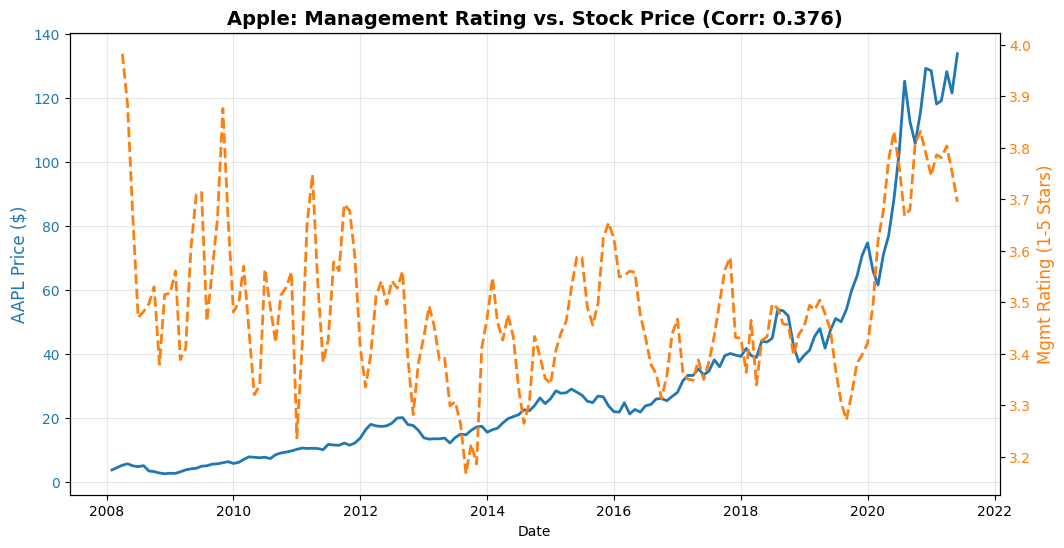

In [7]:
# =============================================================================
# VISUALIZATION PIPELINE: DUAL-AXIS CORRELATION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# CONFIGURATION
# Update this path if you are using Google Drive or local upload
CSV_FILENAME = '/content/drive/MyDrive/glassdoor_reviews.csv'
TARGET_COMPANY = 'Apple'
TARGET_TICKER = 'AAPL'

try:
    # Load and clean data
    df = pd.read_csv(CSV_FILENAME)

    # Standardize column names
    df = df.rename(columns={'date_review': 'date', 'firm': 'company_name'})

    # Filter for target company
    df = df[df['company_name'] == TARGET_COMPANY].copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filter for valid management ratings
    df = df[df['senior_mgmt'] > 0]
    print(f"Reviews Loaded: {len(df)}")

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    raise SystemExit

# DATA PROCESSING
# Create a 'YearMonth' column to align datasets (e.g., 2015-01)
df['YearMonth'] = df['date'].dt.to_period('M')

# Aggregate by month and calculate a 3-month rolling average to smooth volatility
monthly_sentiment = df.groupby('YearMonth')['senior_mgmt'].mean().reset_index()
monthly_sentiment['Rating_Smooth'] = monthly_sentiment['senior_mgmt'].rolling(window=3).mean()

# MARKET DATA ACQUISITION
start_date = df['date'].min()
end_date = df['date'].max()
print(f"Downloading Stock Data ({start_date.date()} - {end_date.date()})...")

stock = yf.download(TARGET_TICKER, start=start_date, end=end_date, interval="1mo", progress=False)

# Handle MultiIndex if present (common in yfinance updates)
if isinstance(stock.columns, pd.MultiIndex):
    stock.columns = stock.columns.get_level_values(0)
stock = stock.reset_index()

# Remove timezone information to allow merging
if stock['Date'].dt.tz is not None:
    stock['Date'] = stock['Date'].dt.tz_localize(None)

# Create 'YearMonth' for stock data
stock['YearMonth'] = stock['Date'].dt.to_period('M')

# DATA MERGING
# Inner join ensures we only analyze months where we have both stock and review data
merged = pd.merge(monthly_sentiment, stock, on='YearMonth', how='inner')

# Calculate Pearson Correlation Coefficient
corr = merged['Rating_Smooth'].corr(merged['Close'])
print(f"Data Aligned. Overlapping Months: {len(merged)}")
print(f"Correlation Coefficient: {corr:.3f}")

# VISUALIZATION
if len(merged) < 2:
    print("Insufficient data to generate plot.")
else:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Stock Price (Left Axis)
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{TARGET_TICKER} Price ($)', color=color, fontsize=12)

    # Convert period objects back to timestamps for matplotlib compatibility
    plot_dates = merged['YearMonth'].dt.to_timestamp()

    ax1.plot(plot_dates, merged['Close'], color=color, linewidth=2, label='Stock Price')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Plot Management Rating (Right Axis)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Mgmt Rating (1-5 Stars)', color=color, fontsize=12)
    ax2.plot(plot_dates, merged['Rating_Smooth'], color=color, linestyle='--', linewidth=2, label='Employee Rating')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'{TARGET_COMPANY}: Management Rating vs. Stock Price (Corr: {corr:.3f})', fontsize=14, fontweight='bold')
    plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
